In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
database = '../stonks_app.db'
connection = sqlite3.connect(database)

In [3]:
ticker = ('AAPL',)
c = connection.cursor()
data = c.execute('select * from historical_prices where ticker=?', ticker)
data = c.fetchall()
data

[(1,
  'AAPL',
  '2019-10-03 00:00:00.000000',
  55.21,
  54.61,
  55.24,
  53.78,
  121410744.0),
 (2,
  'AAPL',
  '2019-10-04 00:00:00.000000',
  56.75,
  56.41,
  56.87,
  55.97,
  139022212.0),
 (3,
  'AAPL',
  '2019-10-07 00:00:00.000000',
  56.77,
  56.57,
  57.48,
  56.46,
  123557076.0),
 (4,
  'AAPL',
  '2019-10-08 00:00:00.000000',
  56.1,
  56.46,
  57.02,
  56.08,
  117130800.0),
 (5,
  'AAPL',
  '2019-10-09 00:00:00.000000',
  56.76,
  56.76,
  56.95,
  56.41,
  76117696.0),
 (6,
  'AAPL',
  '2019-10-10 00:00:00.000000',
  57.52,
  56.98,
  57.61,
  56.83,
  115851936.0),
 (7,
  'AAPL',
  '2019-10-11 00:00:00.000000',
  59.05,
  58.24,
  59.41,
  58.08,
  167960840.0),
 (8,
  'AAPL',
  '2019-10-14 00:00:00.000000',
  58.97,
  58.73,
  59.53,
  58.67,
  97653936.0),
 (9,
  'AAPL',
  '2019-10-15 00:00:00.000000',
  58.83,
  59.1,
  59.41,
  58.72,
  92161932.0),
 (10,
  'AAPL',
  '2019-10-16 00:00:00.000000',
  58.59,
  58.34,
  58.81,
  58.3,
  77146776.0),
 (11,
  'AAPL',


In [4]:
#Читаем данные из БД и сладываем их в датафрем
#Меняем названия колонок на такие как базе
#Кастуем колонку дата в тип даты
ticker = ('AAPL',)
c = connection.cursor()
def create_dataframe(ticker, connection):
    data = c.execute('select * from historical_prices where ticker=?', ticker)
    df = pd.DataFrame(c.fetchall())
    names = [description[0] for description in data.description]
    lst = list(range(0, len(names)))
    new_names = {}
    for (n, i) in zip(names, lst):
        new_names[i] = n
    df.rename(columns=new_names, inplace=True)
    df['date'] = pd.to_datetime(df.date)
    df['date'] = df['date'].dt.strftime('%d/%m/%Y')
    return(df)

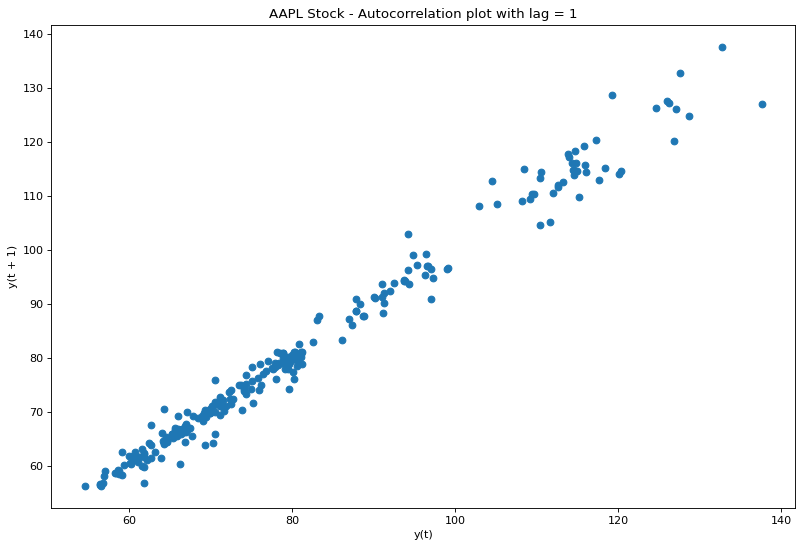

In [5]:
# Проверяем автокорреляцию 
# Зависимость текущего значения данных от предыдущего
# Визуально видно что, автокорреляция есть
# Точки лежат на линии регрессии
df = create_dataframe(ticker, c)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
lag_plot(df['price_open'], lag=1)
plt.title('AAPL Stock - Autocorrelation plot with lag = 1')
plt.show()

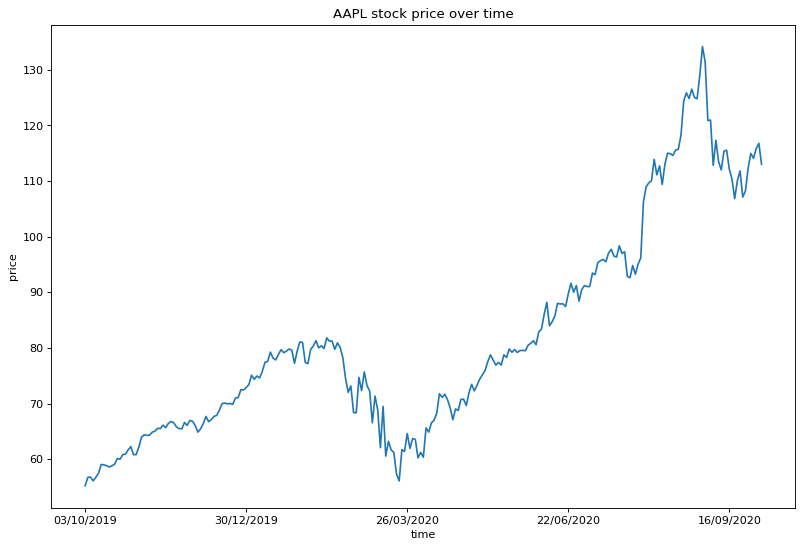

In [6]:
# График цены
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df["date"], df["price_close"])
plt.xticks(np.arange(0,252, 60), df['date'][0:252:60])
plt.title("AAPL stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [7]:
class PrepareDataset:
    '''Класс, который подготавливает датасет. 
    
    Аргументы: 
    df - датафрейм (ожидается что придет структура как из нашей БД),
    train_len - float от 0 до 1, какая часть данных идет в обучение
    test_len - float от 0 до 1, какая часть данных идет в тест
   
   Атрибуты:
    train_data - обучение, numpy.ndarray
    test_data - тест, numpy.ndarray
    '''
    
    def __init__(self, df, train_len, test_len):
        self.train_data, self.test_data = df[0:int(len(df)*train_len)], df[int(len(df)*test_len):]
        self.train_data = self.train_data['price_close'].values
        self.test_data = self.test_data['price_close'].values


In [8]:
class PredictorARIMA:
    def __init__(self, train, test, p, d, q):
        self.train = train
        self.test = test
        self.p = p
        self.d = d
        self.q = q
        self.params = (p,d,q)
        self.predictions = []
    
    def get(self):
        self.predictions = []
        history = [x for x in self.train]
        N_test_observations = len(self.test)
        order = (self.p,self.d,self.q)
        for time_point in range(N_test_observations):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            self.predictions.append(yhat)
            true_test_value = test_data[time_point]
            history.append(true_test_value)
    
    def mse(self):
        error = mean_squared_error(self.test, self.predictions)
        return error


In [9]:
# Функция получения прогноза по ARIMA
# На вход

def get_ARIMA_forecast(train_data, test_data, p, d, q):
    history = [x for x in train_data]
    N_test_observations = len(test_data)
    order = (p,d,q)
    model_predictions = []
    for time_point in range(N_test_observations):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
        print(model_fit.summary())
    return model_predictions

In [10]:
dataset = PrepareDataset(df, 0.7, 0.7)
test_data = dataset.test_data
train_data = dataset.train_data

In [11]:
testc = PredictorARIMA(train_data, test_data, 1, 0, 0)

In [12]:
    history = [x for x in train_data]
    N_test_observations = len(test_data)
    order = (1,0,1)
    model_predictions = []
    model = ARIMA(history, order=order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(7)
    output

(array([87.20018343, 87.10293304, 87.00627669, 86.91021072, 86.81473154,
        86.71983556, 86.62551921]),
 array([1.86348558, 2.30048235, 2.66264872, 2.97746298, 3.25871885,
        3.51451985, 3.75011328]),
 array([[83.5478188 , 90.85254805],
        [82.59407049, 91.6117956 ],
        [81.7875811 , 92.22497227],
        [81.07449051, 92.74593093],
        [80.42775995, 93.20170312],
        [79.83150323, 93.60816788],
        [79.27543224, 93.97560619]]))

In [13]:
testc.params

(1, 0, 0)

In [24]:
# Модель ARMA(,01)
arma1 = get_ARIMA_forecast(train_data, test_data, 1, 0, 0)
MSE = mean_squared_error(test_data, arma1)
MSE

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(1, 0)   Log Likelihood                -370.815
Method:                       css-mle   S.D. of innovations              1.947
Date:                Sat, 31 Oct 2020   AIC                            747.630
Time:                        02:54:25   BIC                            757.159
Sample:                             0   HQIC                           751.495
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.1926      6.714     10.604      0.000      58.034      84.352
ar.L1.y        0.9831      0.015     65.799      0.000       0.954       1.012
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  186
Model:                     ARMA(1, 0)   Log Likelihood                -388.596
Method:                       css-mle   S.D. of innovations              1.936
Date:                Sat, 31 Oct 2020   AIC                            783.193
Time:                        02:54:25   BIC                            792.870
Sample:                             0   HQIC                           787.114
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.2631      7.968      9.069      0.000      56.646      87.880
ar.L1.y        0.9867      0.013     78.727      0.000       0.962       1.011
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  194
Model:                     ARMA(1, 0)   Log Likelihood                -403.079
Method:                       css-mle   S.D. of innovations              1.912
Date:                Sat, 31 Oct 2020   AIC                            812.158
Time:                        02:54:26   BIC                            821.962
Sample:                             0   HQIC                           816.128
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.2518     10.780      6.888      0.000      53.123      95.381
ar.L1.y        0.9914      0.009    105.306      0.000       0.973       1.010
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  201
Model:                     ARMA(1, 0)   Log Likelihood                -415.551
Method:                       css-mle   S.D. of innovations              1.893
Date:                Sat, 31 Oct 2020   AIC                            837.102
Time:                        02:54:26   BIC                            847.011
Sample:                             0   HQIC                           841.111
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.9974     11.688      6.417      0.000      52.089      97.906
ar.L1.y        0.9925      0.008    119.928      0.000       0.976       1.009
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  209
Model:                     ARMA(1, 0)   Log Likelihood                -445.897
Method:                       css-mle   S.D. of innovations              2.021
Date:                Sat, 31 Oct 2020   AIC                            897.794
Time:                        02:54:27   BIC                            907.821
Sample:                             0   HQIC                           901.848
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.4517     15.744      4.983      0.000      47.593     109.310
ar.L1.y        0.9946      0.006    153.240      0.000       0.982       1.007
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  215
Model:                     ARMA(1, 0)   Log Likelihood                -459.874
Method:                       css-mle   S.D. of innovations              2.031
Date:                Sat, 31 Oct 2020   AIC                            925.748
Time:                        02:54:28   BIC                            935.860
Sample:                             0   HQIC                           929.833
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.4867     19.788      4.118      0.000      42.704     120.270
ar.L1.y        0.9962      0.005    207.796      0.000       0.987       1.006
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  221
Model:                     ARMA(1, 0)   Log Likelihood                -473.275
Method:                       css-mle   S.D. of innovations              2.036
Date:                Sat, 31 Oct 2020   AIC                            952.549
Time:                        02:54:28   BIC                            962.744
Sample:                             0   HQIC                           956.666
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.9875     21.530      3.855      0.000      40.790     125.185
ar.L1.y        0.9967      0.004    237.036      0.000       0.988       1.005
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(1, 0)   Log Likelihood                -491.146
Method:                       css-mle   S.D. of innovations              2.061
Date:                Sat, 31 Oct 2020   AIC                            988.292
Time:                        02:54:30   BIC                            998.580
Sample:                             0   HQIC                           992.443
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.5525     27.103      3.230      0.001      34.431     140.674
ar.L1.y        0.9977      0.003    330.340      0.000       0.992       1.004
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  235
Model:                     ARMA(1, 0)   Log Likelihood                -527.163
Method:                       css-mle   S.D. of innovations              2.258
Date:                Sat, 31 Oct 2020   AIC                           1060.326
Time:                        02:54:30   BIC                           1070.705
Sample:                             0   HQIC                          1064.510
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.3746     19.270      4.275      0.000      44.606     120.143
ar.L1.y        0.9955      0.005    195.361      0.000       0.985       1.005
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  241
Model:                     ARMA(1, 0)   Log Likelihood                -543.391
Method:                       css-mle   S.D. of innovations              2.284
Date:                Sat, 31 Oct 2020   AIC                           1092.781
Time:                        02:54:31   BIC                           1103.236
Sample:                             0   HQIC                          1096.993
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.4001     18.890      4.362      0.000      45.377     119.423
ar.L1.y        0.9953      0.005    193.014      0.000       0.985       1.005
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  247
Model:                     ARMA(1, 0)   Log Likelihood                -558.723
Method:                       css-mle   S.D. of innovations              2.302
Date:                Sat, 31 Oct 2020   AIC                           1123.446
Time:                        02:54:31   BIC                           1133.974
Sample:                             0   HQIC                          1127.684
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.3773     17.279      4.710      0.000      47.511     115.243
ar.L1.y        0.9946      0.006    180.551      0.000       0.984       1.005
                                    Roots           

9.069647907048866

In [15]:
# Модель ARMA(2,0)
arma2 = get_ARIMA_forecast(train_data, test_data, 2, 0, 0)
MSE = mean_squared_error(test_data, arma2)
MSE

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(2, 0)   Log Likelihood                -361.827
Method:                       css-mle   S.D. of innovations              1.848
Date:                Sat, 31 Oct 2020   AIC                            731.653
Time:                        02:33:40   BIC                            744.358
Sample:                             0   HQIC                           736.806
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.3004      9.728      7.329      0.000      52.234      90.367
ar.L1.y        0.6771      0.072      9.468      0.000       0.537       0.817
ar.L2.y        0.3142      0.072      4.366      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  183
Model:                     ARMA(2, 0)   Log Likelihood                -373.084
Method:                       css-mle   S.D. of innovations              1.838
Date:                Sat, 31 Oct 2020   AIC                            754.167
Time:                        02:33:41   BIC                            767.005
Sample:                             0   HQIC                           759.371
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.5096     11.337      6.396      0.000      50.290      94.729
ar.L1.y        0.6849      0.070      9.738      0.000       0.547       0.823
ar.L2.y        0.3083      0.071      4.356      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  189
Model:                     ARMA(2, 0)   Log Likelihood                -383.697
Method:                       css-mle   S.D. of innovations              1.822
Date:                Sat, 31 Oct 2020   AIC                            775.394
Time:                        02:33:42   BIC                            788.361
Sample:                             0   HQIC                           780.648
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.9362     11.853      6.153      0.000      49.704      96.168
ar.L1.y        0.6785      0.069      9.847      0.000       0.543       0.814
ar.L2.y        0.3152      0.069      4.551      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  195
Model:                     ARMA(2, 0)   Log Likelihood                -394.762
Method:                       css-mle   S.D. of innovations              1.811
Date:                Sat, 31 Oct 2020   AIC                            797.525
Time:                        02:33:43   BIC                            810.617
Sample:                             0   HQIC                           802.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.8865     14.469      5.176      0.000      46.529     103.244
ar.L1.y        0.6833      0.068     10.055      0.000       0.550       0.816
ar.L2.y        0.3122      0.068      4.577      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  201
Model:                     ARMA(2, 0)   Log Likelihood                -405.289
Method:                       css-mle   S.D. of innovations              1.796
Date:                Sat, 31 Oct 2020   AIC                            818.578
Time:                        02:33:44   BIC                            831.791
Sample:                             0   HQIC                           823.925
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.7797     15.570      4.867      0.000      45.263     106.297
ar.L1.y        0.6827      0.067     10.190      0.000       0.551       0.814
ar.L2.y        0.3134      0.067      4.662      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  207
Model:                     ARMA(2, 0)   Log Likelihood                -418.599
Method:                       css-mle   S.D. of innovations              1.808
Date:                Sat, 31 Oct 2020   AIC                            845.199
Time:                        02:33:45   BIC                            858.530
Sample:                             0   HQIC                           850.590
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.8386     14.020      5.338      0.000      47.360     102.317
ar.L1.y        0.6845      0.066     10.351      0.000       0.555       0.814
ar.L2.y        0.3108      0.066      4.684      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  212
Model:                     ARMA(2, 0)   Log Likelihood                -446.628
Method:                       css-mle   S.D. of innovations              1.966
Date:                Sat, 31 Oct 2020   AIC                            901.256
Time:                        02:33:46   BIC                            914.682
Sample:                             0   HQIC                           906.682
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.1807     21.193      3.831      0.000      39.643     122.719
ar.L1.y        0.7770      0.067     11.607      0.000       0.646       0.908
ar.L2.y        0.2202      0.067      3.281      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  217
Model:                     ARMA(2, 0)   Log Likelihood                -459.404
Method:                       css-mle   S.D. of innovations              1.986
Date:                Sat, 31 Oct 2020   AIC                            926.808
Time:                        02:33:47   BIC                            940.327
Sample:                             0   HQIC                           932.269
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.4271     22.680      3.634      0.000      37.975     126.879
ar.L1.y        0.7510      0.066     11.342      0.000       0.621       0.881
ar.L2.y        0.2465      0.066      3.715      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  223
Model:                     ARMA(2, 0)   Log Likelihood                -471.208
Method:                       css-mle   S.D. of innovations              1.978
Date:                Sat, 31 Oct 2020   AIC                            950.416
Time:                        02:33:48   BIC                            964.045
Sample:                             0   HQIC                           955.918
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.1346     25.818      3.297      0.001      34.532     135.738
ar.L1.y        0.7641      0.065     11.722      0.000       0.636       0.892
ar.L2.y        0.2338      0.065      3.581      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  228
Model:                     ARMA(2, 0)   Log Likelihood                -493.279
Method:                       css-mle   S.D. of innovations              2.014
Date:                Sat, 31 Oct 2020   AIC                            994.559
Time:                        02:33:49   BIC                           1008.276
Sample:                             0   HQIC                          1000.093
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.4252        nan        nan        nan         nan         nan
ar.L1.y        0.7963   6.59e-06   1.21e+05      0.000       0.796       0.796
ar.L2.y        0.2037   1.69e-06   1.21e+05      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  234
Model:                     ARMA(2, 0)   Log Likelihood                -516.676
Method:                       css-mle   S.D. of innovations              2.177
Date:                Sat, 31 Oct 2020   AIC                           1041.352
Time:                        02:33:50   BIC                           1055.174
Sample:                             0   HQIC                          1046.925
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.3268     25.810      3.345      0.001      35.740     136.913
ar.L1.y        0.8569      0.065     13.261      0.000       0.730       0.984
ar.L2.y        0.1405      0.065      2.170      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  239
Model:                     ARMA(2, 0)   Log Likelihood                -535.329
Method:                       css-mle   S.D. of innovations              2.249
Date:                Sat, 31 Oct 2020   AIC                           1078.658
Time:                        02:33:51   BIC                           1092.564
Sample:                             0   HQIC                          1084.262
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.8391     22.415      3.740      0.000      39.906     127.772
ar.L1.y        0.8247      0.064     12.897      0.000       0.699       0.950
ar.L2.y        0.1720      0.064      2.683      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  245
Model:                     ARMA(2, 0)   Log Likelihood                -549.977
Method:                       css-mle   S.D. of innovations              2.262
Date:                Sat, 31 Oct 2020   AIC                           1107.954
Time:                        02:33:52   BIC                           1121.959
Sample:                             0   HQIC                          1113.594
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.6892     20.602      4.014      0.000      42.310     123.068
ar.L1.y        0.8364      0.063     13.261      0.000       0.713       0.960
ar.L2.y        0.1599      0.063      2.528      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  251
Model:                     ARMA(2, 0)   Log Likelihood                -565.471
Method:                       css-mle   S.D. of innovations              2.280
Date:                Sat, 31 Oct 2020   AIC                           1138.942
Time:                        02:33:53   BIC                           1153.044
Sample:                             0   HQIC                          1144.617
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.4089     22.327      3.781      0.000      40.649     128.169
ar.L1.y        0.8415      0.062     13.494      0.000       0.719       0.964
ar.L2.y        0.1552      0.063      2.483      0.0

9.598716651231241

In [211]:
# Модель ARIMA(4,1,0)
arima_410 = get_ARIMA_forecast(train_data, test_data, 4, 1, 0)
MSE = mean_squared_error(test_data, arima_410)
MSE

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  176
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -356.110
Method:                       css-mle   S.D. of innovations              1.829
Date:                Mon, 19 Oct 2020   AIC                            724.219
Time:                        02:32:28   BIC                            743.242
Sample:                             1   HQIC                           731.935
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1826      0.105      1.739      0.082      -0.023       0.388
ar.L1.D.y     -0.3230      0.076     -4.274      0.000      -0.471      -0.175
ar.L2.D.y      0.0296      0.079      0.372      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  178
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -359.166
Method:                       css-mle   S.D. of innovations              1.819
Date:                Mon, 19 Oct 2020   AIC                            730.332
Time:                        02:32:28   BIC                            749.423
Sample:                             1   HQIC                           738.074
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1817      0.104      1.754      0.079      -0.021       0.385
ar.L1.D.y     -0.3228      0.075     -4.320      0.000      -0.469      -0.176
ar.L2.D.y      0.0286      0.078      0.365      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  180
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -362.886
Method:                       css-mle   S.D. of innovations              1.816
Date:                Mon, 19 Oct 2020   AIC                            737.772
Time:                        02:32:29   BIC                            756.930
Sample:                             1   HQIC                           745.540
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1871      0.103      1.822      0.069      -0.014       0.388
ar.L1.D.y     -0.3251      0.075     -4.361      0.000      -0.471      -0.179
ar.L2.D.y      0.0265      0.078      0.339      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  182
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -367.044
Method:                       css-mle   S.D. of innovations              1.817
Date:                Mon, 19 Oct 2020   AIC                            746.089
Time:                        02:32:29   BIC                            765.313
Sample:                             1   HQIC                           753.882
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1918      0.102      1.885      0.059      -0.008       0.391
ar.L1.D.y     -0.3226      0.074     -4.359      0.000      -0.468      -0.178
ar.L2.D.y      0.0203      0.078      0.261      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  184
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -371.070
Method:                       css-mle   S.D. of innovations              1.817
Date:                Mon, 19 Oct 2020   AIC                            754.140
Time:                        02:32:29   BIC                            773.430
Sample:                             1   HQIC                           761.959
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1826      0.100      1.823      0.068      -0.014       0.379
ar.L1.D.y     -0.3245      0.074     -4.391      0.000      -0.469      -0.180
ar.L2.D.y      0.0262      0.078      0.338      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  186
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -374.436
Method:                       css-mle   S.D. of innovations              1.811
Date:                Mon, 19 Oct 2020   AIC                            760.872
Time:                        02:32:30   BIC                            780.227
Sample:                             1   HQIC                           768.715
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1910      0.098      1.940      0.052      -0.002       0.384
ar.L1.D.y     -0.3272      0.073     -4.472      0.000      -0.471      -0.184
ar.L2.D.y      0.0212      0.077      0.275      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  188
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -377.500
Method:                       css-mle   S.D. of innovations              1.802
Date:                Mon, 19 Oct 2020   AIC                            766.999
Time:                        02:32:30   BIC                            786.418
Sample:                             1   HQIC                           774.867
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1885      0.097      1.935      0.053      -0.002       0.379
ar.L1.D.y     -0.3273      0.073     -4.503      0.000      -0.470      -0.185
ar.L2.D.y      0.0200      0.076      0.261      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  190
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -381.322
Method:                       css-mle   S.D. of innovations              1.800
Date:                Mon, 19 Oct 2020   AIC                            774.643
Time:                        02:32:30   BIC                            794.125
Sample:                             1   HQIC                           782.535
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1987      0.098      2.037      0.042       0.007       0.390
ar.L1.D.y     -0.3277      0.072     -4.530      0.000      -0.469      -0.186
ar.L2.D.y      0.0190      0.076      0.249      0.8

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  192
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -384.885
Method:                       css-mle   S.D. of innovations              1.796
Date:                Mon, 19 Oct 2020   AIC                            781.770
Time:                        02:32:31   BIC                            801.315
Sample:                             1   HQIC                           789.685
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2085      0.098      2.133      0.033       0.017       0.400
ar.L1.D.y     -0.3249      0.072     -4.513      0.000      -0.466      -0.184
ar.L2.D.y      0.0264      0.076      0.348      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  194
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -387.969
Method:                       css-mle   S.D. of innovations              1.787
Date:                Mon, 19 Oct 2020   AIC                            787.938
Time:                        02:32:31   BIC                            807.546
Sample:                             1   HQIC                           795.878
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2063      0.097      2.135      0.033       0.017       0.396
ar.L1.D.y     -0.3248      0.072     -4.535      0.000      -0.465      -0.184
ar.L2.D.y      0.0259      0.075      0.345      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  196
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -391.345
Method:                       css-mle   S.D. of innovations              1.781
Date:                Mon, 19 Oct 2020   AIC                            794.690
Time:                        02:32:31   BIC                            814.358
Sample:                             1   HQIC                           802.652
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2148      0.096      2.233      0.026       0.026       0.403
ar.L1.D.y     -0.3245      0.071     -4.552      0.000      -0.464      -0.185
ar.L2.D.y      0.0252      0.075      0.336      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  198
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -394.733
Method:                       css-mle   S.D. of innovations              1.776
Date:                Mon, 19 Oct 2020   AIC                            801.467
Time:                        02:32:31   BIC                            821.196
Sample:                             1   HQIC                           809.453
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2063      0.095      2.170      0.030       0.020       0.393
ar.L1.D.y     -0.3245      0.071     -4.576      0.000      -0.464      -0.186
ar.L2.D.y      0.0214      0.075      0.287      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  200
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -398.348
Method:                       css-mle   S.D. of innovations              1.773
Date:                Mon, 19 Oct 2020   AIC                            808.696
Time:                        02:32:32   BIC                            828.486
Sample:                             1   HQIC                           816.705
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2095      0.094      2.220      0.026       0.025       0.394
ar.L1.D.y     -0.3296      0.071     -4.670      0.000      -0.468      -0.191
ar.L2.D.y      0.0174      0.074      0.234      0.8

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  202
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -404.732
Method:                       css-mle   S.D. of innovations              1.794
Date:                Mon, 19 Oct 2020   AIC                            821.463
Time:                        02:32:32   BIC                            841.313
Sample:                             1   HQIC                           829.494
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1902      0.095      2.000      0.045       0.004       0.377
ar.L1.D.y     -0.3254      0.071     -4.559      0.000      -0.465      -0.186
ar.L2.D.y      0.0244      0.075      0.325      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  204
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -408.795
Method:                       css-mle   S.D. of innovations              1.794
Date:                Mon, 19 Oct 2020   AIC                            829.590
Time:                        02:32:32   BIC                            849.499
Sample:                             1   HQIC                           837.643
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1907      0.094      2.034      0.042       0.007       0.374
ar.L1.D.y     -0.3179      0.070     -4.539      0.000      -0.455      -0.181
ar.L2.D.y      0.0147      0.073      0.200      0.8

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  206
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -412.060
Method:                       css-mle   S.D. of innovations              1.788
Date:                Mon, 19 Oct 2020   AIC                            836.121
Time:                        02:32:32   BIC                            856.088
Sample:                             1   HQIC                           844.196
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1897      0.093      2.036      0.042       0.007       0.372
ar.L1.D.y     -0.3221      0.070     -4.634      0.000      -0.458      -0.186
ar.L2.D.y      0.0186      0.073      0.255      0.7

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  208
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -430.613
Method:                       css-mle   S.D. of innovations              1.918
Date:                Mon, 19 Oct 2020   AIC                            873.225
Time:                        02:32:33   BIC                            893.251
Sample:                             1   HQIC                           881.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2338      0.104      2.246      0.025       0.030       0.438
ar.L1.D.y     -0.2975      0.074     -4.001      0.000      -0.443      -0.152
ar.L2.D.y      0.0398      0.078      0.510      0.6

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  210
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -436.967
Method:                       css-mle   S.D. of innovations              1.938
Date:                Mon, 19 Oct 2020   AIC                            885.935
Time:                        02:32:33   BIC                            906.017
Sample:                             1   HQIC                           894.053
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2576      0.114      2.250      0.024       0.033       0.482
ar.L1.D.y     -0.2262      0.069     -3.287      0.001      -0.361      -0.091
ar.L2.D.y      0.0775      0.072      1.082      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  212
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -441.891
Method:                       css-mle   S.D. of innovations              1.945
Date:                Mon, 19 Oct 2020   AIC                            895.782
Time:                        02:32:33   BIC                            915.922
Sample:                             1   HQIC                           903.922
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2747      0.122      2.258      0.024       0.036       0.513
ar.L1.D.y     -0.2274      0.069     -3.292      0.001      -0.363      -0.092
ar.L2.D.y      0.0783      0.071      1.108      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  214
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -445.758
Method:                       css-mle   S.D. of innovations              1.942
Date:                Mon, 19 Oct 2020   AIC                            903.516
Time:                        02:32:33   BIC                            923.712
Sample:                             1   HQIC                           911.677
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2663      0.119      2.243      0.025       0.034       0.499
ar.L1.D.y     -0.2383      0.068     -3.491      0.000      -0.372      -0.105
ar.L2.D.y      0.0772      0.070      1.100      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  216
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -451.029
Method:                       css-mle   S.D. of innovations              1.952
Date:                Mon, 19 Oct 2020   AIC                            914.059
Time:                        02:32:34   BIC                            934.311
Sample:                             1   HQIC                           922.241
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2632      0.117      2.249      0.025       0.034       0.493
ar.L1.D.y     -0.2490      0.068     -3.653      0.000      -0.383      -0.115
ar.L2.D.y      0.0845      0.070      1.201      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  218
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -455.253
Method:                       css-mle   S.D. of innovations              1.953
Date:                Mon, 19 Oct 2020   AIC                            922.506
Time:                        02:32:34   BIC                            942.813
Sample:                             1   HQIC                           930.708
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2741      0.116      2.373      0.018       0.048       0.500
ar.L1.D.y     -0.2411      0.068     -3.565      0.000      -0.374      -0.109
ar.L2.D.y      0.0755      0.070      1.083      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  220
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -458.558
Method:                       css-mle   S.D. of innovations              1.945
Date:                Mon, 19 Oct 2020   AIC                            929.117
Time:                        02:32:34   BIC                            949.479
Sample:                             1   HQIC                           937.339
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2728      0.115      2.382      0.017       0.048       0.497
ar.L1.D.y     -0.2415      0.067     -3.587      0.000      -0.373      -0.110
ar.L2.D.y      0.0724      0.069      1.047      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  222
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -462.382
Method:                       css-mle   S.D. of innovations              1.942
Date:                Mon, 19 Oct 2020   AIC                            936.763
Time:                        02:32:35   BIC                            957.179
Sample:                             1   HQIC                           945.006
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2819      0.114      2.478      0.013       0.059       0.505
ar.L1.D.y     -0.2412      0.067     -3.589      0.000      -0.373      -0.109
ar.L2.D.y      0.0739      0.069      1.071      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  224
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -471.407
Method:                       css-mle   S.D. of innovations              1.985
Date:                Mon, 19 Oct 2020   AIC                            954.813
Time:                        02:32:35   BIC                            975.283
Sample:                             1   HQIC                           963.076
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3170      0.121      2.622      0.009       0.080       0.554
ar.L1.D.y     -0.2078      0.067     -3.107      0.002      -0.339      -0.077
ar.L2.D.y      0.0883      0.070      1.262      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  226
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -475.044
Method:                       css-mle   S.D. of innovations              1.980
Date:                Mon, 19 Oct 2020   AIC                            962.087
Time:                        02:32:35   BIC                            982.611
Sample:                             1   HQIC                           970.370
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3138      0.119      2.645      0.008       0.081       0.546
ar.L1.D.y     -0.2135      0.066     -3.214      0.001      -0.344      -0.083
ar.L2.D.y      0.0775      0.068      1.142      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  228
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -478.630
Method:                       css-mle   S.D. of innovations              1.974
Date:                Mon, 19 Oct 2020   AIC                            969.260
Time:                        02:32:35   BIC                            989.836
Sample:                             1   HQIC                           977.561
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3042      0.117      2.610      0.009       0.076       0.533
ar.L1.D.y     -0.2134      0.066     -3.227      0.001      -0.343      -0.084
ar.L2.D.y      0.0789      0.068      1.168      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  230
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -487.825
Method:                       css-mle   S.D. of innovations              2.018
Date:                Mon, 19 Oct 2020   AIC                            987.650
Time:                        02:32:36   BIC                           1008.278
Sample:                             1   HQIC                           995.971
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3417      0.119      2.865      0.004       0.108       0.575
ar.L1.D.y     -0.1929      0.067     -2.879      0.004      -0.324      -0.062
ar.L2.D.y      0.0708      0.069      1.026      0.3

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  232
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -506.925
Method:                       css-mle   S.D. of innovations              2.151
Date:                Mon, 19 Oct 2020   AIC                           1025.850
Time:                        02:32:36   BIC                           1046.530
Sample:                             1   HQIC                          1034.190
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2909      0.114      2.542      0.011       0.067       0.515
ar.L1.D.y     -0.1784      0.070     -2.550      0.011      -0.316      -0.041
ar.L2.D.y     -0.0067      0.072     -0.094      0.9

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  234
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -517.215
Method:                       css-mle   S.D. of innovations              2.206
Date:                Mon, 19 Oct 2020   AIC                           1046.430
Time:                        02:32:36   BIC                           1067.162
Sample:                             1   HQIC                          1054.789
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2532      0.129      1.969      0.049       0.001       0.505
ar.L1.D.y     -0.1458      0.067     -2.173      0.030      -0.277      -0.014
ar.L2.D.y      0.0938      0.068      1.383      0.1

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  236
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -522.150
Method:                       css-mle   S.D. of innovations              2.211
Date:                Mon, 19 Oct 2020   AIC                           1056.299
Time:                        02:32:36   BIC                           1077.082
Sample:                             1   HQIC                          1064.677
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2514      0.127      1.981      0.048       0.003       0.500
ar.L1.D.y     -0.1697      0.065     -2.605      0.009      -0.297      -0.042
ar.L2.D.y      0.1070      0.066      1.619      0.1

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  238
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -527.508
Method:                       css-mle   S.D. of innovations              2.220
Date:                Mon, 19 Oct 2020   AIC                           1067.015
Time:                        02:32:37   BIC                           1087.849
Sample:                             1   HQIC                          1075.412
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2506      0.127      1.979      0.048       0.002       0.499
ar.L1.D.y     -0.1707      0.065     -2.629      0.009      -0.298      -0.043
ar.L2.D.y      0.0923      0.066      1.400      0.1

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  240
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -532.688
Method:                       css-mle   S.D. of innovations              2.227
Date:                Mon, 19 Oct 2020   AIC                           1077.376
Time:                        02:32:37   BIC                           1098.260
Sample:                             1   HQIC                          1085.791
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2380      0.128      1.865      0.062      -0.012       0.488
ar.L1.D.y     -0.1707      0.065     -2.633      0.008      -0.298      -0.044
ar.L2.D.y      0.0793      0.066      1.208      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  242
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -538.153
Method:                       css-mle   S.D. of innovations              2.236
Date:                Mon, 19 Oct 2020   AIC                           1088.305
Time:                        02:32:37   BIC                           1109.239
Sample:                             1   HQIC                          1096.738
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2148      0.129      1.660      0.097      -0.039       0.468
ar.L1.D.y     -0.1542      0.065     -2.390      0.017      -0.281      -0.028
ar.L2.D.y      0.0927      0.065      1.417      0.1

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  244
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -542.681
Method:                       css-mle   S.D. of innovations              2.237
Date:                Mon, 19 Oct 2020   AIC                           1097.362
Time:                        02:32:37   BIC                           1118.345
Sample:                             1   HQIC                          1105.813
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2320      0.125      1.860      0.063      -0.012       0.476
ar.L1.D.y     -0.1576      0.064     -2.462      0.014      -0.283      -0.032
ar.L2.D.y      0.0802      0.065      1.236      0.2

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  246
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -548.669
Method:                       css-mle   S.D. of innovations              2.251
Date:                Mon, 19 Oct 2020   AIC                           1109.338
Time:                        02:32:38   BIC                           1130.370
Sample:                             1   HQIC                          1117.806
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2135      0.126      1.699      0.089      -0.033       0.460
ar.L1.D.y     -0.1665      0.064     -2.616      0.009      -0.291      -0.042
ar.L2.D.y      0.0678      0.065      1.043      0.

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  247
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -552.268
Method:                       css-mle   S.D. of innovations              2.263
Date:                Mon, 19 Oct 2020   AIC                           1116.537
Time:                        02:32:38   BIC                           1137.593
Sample:                             1   HQIC                          1125.014
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2290      0.126      1.816      0.069      -0.018       0.476
ar.L1.D.y     -0.1664      0.064     -2.601      0.009      -0.292      -0.041
ar.L2.D.y      0.0507      0.065      0.782      0.4

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  249
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -556.677
Method:                       css-mle   S.D. of innovations              2.263
Date:                Mon, 19 Oct 2020   AIC                           1125.354
Time:                        02:32:38   BIC                           1146.459
Sample:                             1   HQIC                          1133.849
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2361      0.125      1.881      0.060      -0.010       0.482
ar.L1.D.y     -0.1585      0.063     -2.505      0.012      -0.283      -0.034
ar.L2.D.y      0.0487      0.064      0.759      0.4

c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\dell\appdata\local\pypoetry\cache\virtualenvs\stonks-app-evqsogbk-py3.8\lib\site-packages\statsmo

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  251
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -560.423
Method:                       css-mle   S.D. of innovations              2.256
Date:                Mon, 19 Oct 2020   AIC                           1132.845
Time:                        02:32:38   BIC                           1153.998
Sample:                             1   HQIC                          1141.357
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2447      0.126      1.938      0.053      -0.003       0.492
ar.L1.D.y     -0.1584      0.063     -2.512      0.012      -0.282      -0.035
ar.L2.D.y      0.0509      0.064      0.799      0.4

9.810446324107746

In [16]:
# Модель ARMA(1,4)
# Любые ARMA модели не работают, т.к. ряд нестационарен
arma14 = get_ARIMA_forecast(train_data, test_data, 1, 0, 4)
MSE = mean_squared_error(test_data, arma14)
MSE

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(1, 4)   Log Likelihood                -361.472
Method:                       css-mle   S.D. of innovations              1.845
Date:                Sat, 31 Oct 2020   AIC                            736.943
Time:                        02:33:56   BIC                            759.176
Sample:                             0   HQIC                           745.960
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.2983      8.902      8.009      0.000      53.850      88.747
ar.L1.y        0.9914      0.010     97.475      0.000       0.971       1.011
ma.L1.y       -0.3081      0.077     -3.990      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  181
Model:                     ARMA(1, 4)   Log Likelihood                -368.423
Method:                       css-mle   S.D. of innovations              1.832
Date:                Sat, 31 Oct 2020   AIC                            750.845
Time:                        02:33:58   BIC                            773.235
Sample:                             0   HQIC                           759.922
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9517      9.781      7.356      0.000      52.781      91.122
ar.L1.y        0.9925      0.009    109.818      0.000       0.975       1.010
ma.L1.y       -0.3090      0.076     -4.069      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  185
Model:                     ARMA(1, 4)   Log Likelihood                -376.647
Method:                       css-mle   S.D. of innovations              1.834
Date:                Sat, 31 Oct 2020   AIC                            767.295
Time:                        02:34:00   BIC                            789.837
Sample:                             0   HQIC                           776.431
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.0123      9.760      7.378      0.000      52.883      91.142
ar.L1.y        0.9926      0.009    112.197      0.000       0.975       1.010
ma.L1.y       -0.3077      0.076     -4.063      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  189
Model:                     ARMA(1, 4)   Log Likelihood                -383.359
Method:                       css-mle   S.D. of innovations              1.819
Date:                Sat, 31 Oct 2020   AIC                            780.719
Time:                        02:34:01   BIC                            803.411
Sample:                             0   HQIC                           789.912
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.8561     11.012      6.616      0.000      51.272      94.440
ar.L1.y        0.9940      0.007    133.271      0.000       0.979       1.009
ma.L1.y       -0.3117      0.074     -4.197      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  193
Model:                     ARMA(1, 4)   Log Likelihood                -391.254
Method:                       css-mle   S.D. of innovations              1.816
Date:                Sat, 31 Oct 2020   AIC                            796.507
Time:                        02:34:03   BIC                            819.346
Sample:                             0   HQIC                           805.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.7396     13.514      5.531      0.000      48.253     101.226
ar.L1.y        0.9955      0.006    169.023      0.000       0.984       1.007
ma.L1.y       -0.3070      0.073     -4.190      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  197
Model:                     ARMA(1, 4)   Log Likelihood                -397.895
Method:                       css-mle   S.D. of innovations              1.802
Date:                Sat, 31 Oct 2020   AIC                            809.790
Time:                        02:34:06   BIC                            832.772
Sample:                             0   HQIC                           819.093
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.6130     14.632      5.168      0.000      46.934     104.292
ar.L1.y        0.9960      0.005    190.465      0.000       0.986       1.006
ma.L1.y       -0.3068      0.072     -4.238      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  201
Model:                     ARMA(1, 4)   Log Likelihood                -404.822
Method:                       css-mle   S.D. of innovations              1.792
Date:                Sat, 31 Oct 2020   AIC                            823.644
Time:                        02:34:08   BIC                            846.767
Sample:                             0   HQIC                           833.001
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.5942     14.523      5.205      0.000      47.130     104.058
ar.L1.y        0.9960      0.005    193.675      0.000       0.986       1.006
ma.L1.y       -0.3115      0.071     -4.356      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  205
Model:                     ARMA(1, 4)   Log Likelihood                -414.801
Method:                       css-mle   S.D. of innovations              1.811
Date:                Sat, 31 Oct 2020   AIC                            843.601
Time:                        02:34:09   BIC                            866.862
Sample:                             0   HQIC                           853.010
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.5119     12.819      5.812      0.000      49.387      99.637
ar.L1.y        0.9952      0.006    168.655      0.000       0.984       1.007
ma.L1.y       -0.3059      0.071     -4.303      0.0

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [21]:
# Проверяем бейзлайн - прогноз = значение предыдущего дня
# Бейзлайн хуже, тк MSE больше
train_data3, test_data3 = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data3 = train_data3['price_close'].values
test_data3 = test_data3['price_close'].values
history3 = [x for x in training_data3]

type(history3)
model_predictions_3 = []
N_test_observations_3 = len(test_data3)
for time_point in range(N_test_observations_3):
    output = history3[-1]
    yhat = output
    model_predictions_3.append(yhat)
    true_test_value = test_data3[time_point]
    history3.append(true_test_value)
MSE_error3 = mean_squared_error(test_data3, model_predictions_3)
print('Testing MSE for baseline is {}'.format(MSE_error3))

Testing MSE for baseline is 8.926718421052641


In [22]:
def get_AR_forecast(train_data, test_data, p):
    history = [x for x in train_data]
    N_test_observations = len(test_data)
    model_predictions = []
    for time_point in range(N_test_observations):
        model = AutoReg(history, lags=p)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
        print(model_fit.summary())
    return model_predictions

arrr1 = get_AR_forecast(train_data, test_data, 1)
MSE = mean_squared_error(test_data, arrr1)
MSE

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  177
Model:                     AutoReg(1)   Log Likelihood                -365.431
Method:               Conditional MLE   S.D. of innovations              1.930
Date:                Sat, 31 Oct 2020   AIC                              1.349
Time:                        02:36:19   BIC                              1.403
Sample:                             1   HQIC                             1.371
                                  177                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2390      1.331      1.682      0.093      -0.370       4.848
y.L1           0.9710      0.019     51.964      0.000       0.934       1.008
                                    Roots           

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  203
Model:                     AutoReg(1)   Log Likelihood                -415.636
Method:               Conditional MLE   S.D. of innovations              1.894
Date:                Sat, 31 Oct 2020   AIC                              1.307
Time:                        02:36:19   BIC                              1.356
Sample:                             1   HQIC                             1.327
                                  203                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3725      0.949      1.446      0.148      -0.488       3.233
y.L1           0.9839      0.013     77.105      0.000       0.959       1.009
                                    Roots           

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  228
Model:                     AutoReg(1)   Log Likelihood                -483.484
Method:               Conditional MLE   S.D. of innovations              2.036
Date:                Sat, 31 Oct 2020   AIC                              1.448
Time:                        02:36:19   BIC                              1.494
Sample:                             1   HQIC                             1.467
                                  228                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2409      0.691     -0.349      0.727      -1.595       1.113
y.L1           1.0071      0.009    115.462      0.000       0.990       1.024
                                    Roots           

9.20899691493179

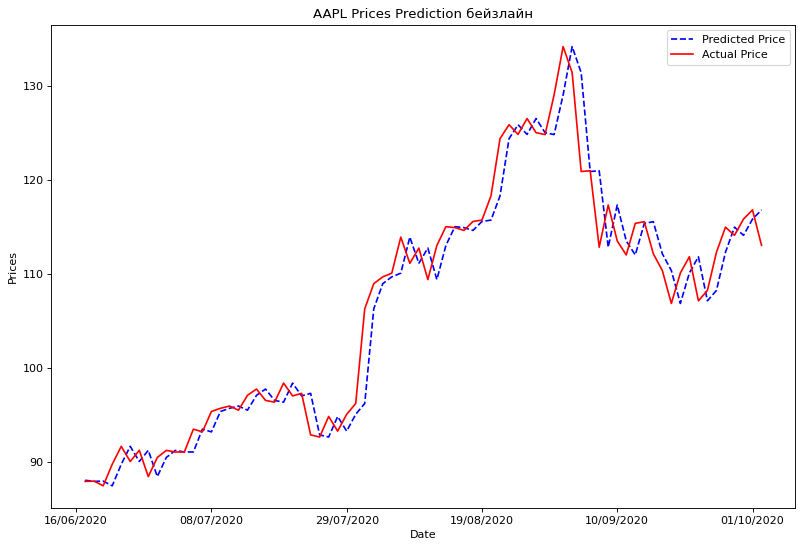

In [18]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions_3, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, dataset.test_data, color='red', label='Actual Price')
plt.title('AAPL Prices Prediction бейзлайн')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(176,252, 15), df['date'][176:252:15])
plt.legend()

plt.show()

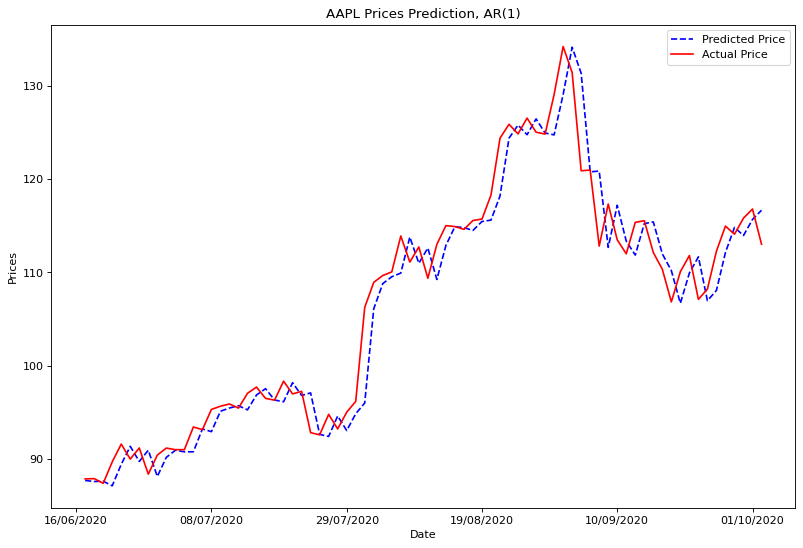

In [20]:
# визуально графики практически идентичны, предсказание очень так себе
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, arma1, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('AAPL Prices Prediction, AR(1)')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(176,252, 15), df['date'][176:252:15])
plt.legend()
plt.show()

In [27]:
test = []
for i in arma1:
    var = float(i)
    test.append(var)
df_new = df[int(len(df)*0.7):]
df_new['forecast_price'] = test
df_new

,id,ticker,date,price_close,price_open,price_high,price_low,volume,forecast_price
177,178,AAPL,17/06/2020,87.90,88.79,88.85,87.77,114406504.0,87.734789
178,179,AAPL,18/06/2020,87.93,87.85,88.36,87.31,96820384.0,87.620700
179,180,AAPL,19/06/2020,87.43,88.66,89.14,86.29,264475808.0,87.656695
180,181,AAPL,22/06/2020,89.72,87.84,89.87,87.79,135445264.0,87.161309
181,182,AAPL,23/06/2020,91.63,91.00,93.10,90.57,212155476.0,89.460229
...,...,...,...,...,...,...,...,...,...
248,249,AAPL,28/09/2020,114.96,115.01,115.32,112.78,137672403.0,112.138454
249,250,AAPL,29/09/2020,114.09,114.55,115.31,113.57,100060526.0,114.822507
250,251,AAPL,30/09/2020,115.81,113.79,117.26,113.62,142675184.0,113.952263
251,252,AAPL,01/10/2020,116.79,117.64,117.72,115.83,116120440.0,115.675667


In [253]:
train_stat = train_data
train_stat = np.log(train_stat)
test_stat = np.log(test_data)

In [255]:
test_log = get_ARIMA_forecast(train_stat, test_stat, 1, 0, 0)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(1, 0)   Log Likelihood                 376.540
Method:                       css-mle   S.D. of innovations              0.029
Date:                Tue, 20 Oct 2020   AIC                           -747.080
Time:                        00:11:20   BIC                           -737.551
Sample:                             0   HQIC                          -743.215
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2512      0.091     46.544      0.000       4.072       4.430
ar.L1.y        0.9814      0.016     62.303      0.000       0.951       1.012
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  183
Model:                     ARMA(1, 0)   Log Likelihood                 391.334
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -776.669
Time:                        00:11:21   BIC                           -767.040
Sample:                             0   HQIC                          -772.766
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2600      0.102     41.691      0.000       4.060       4.460
ar.L1.y        0.9842      0.014     69.916      0.000       0.957       1.012
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  191
Model:                     ARMA(1, 0)   Log Likelihood                 410.828
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -815.656
Time:                        00:11:21   BIC                           -805.899
Sample:                             0   HQIC                          -811.704
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2731      0.119     35.958      0.000       4.040       4.506
ar.L1.y        0.9874      0.012     81.789      0.000       0.964       1.011
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  197
Model:                     ARMA(1, 0)   Log Likelihood                 426.031
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -846.062
Time:                        00:11:22   BIC                           -836.213
Sample:                             0   HQIC                          -842.075
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2897      0.143     29.983      0.000       4.009       4.570
ar.L1.y        0.9904      0.010     98.285      0.000       0.971       1.010
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  203
Model:                     ARMA(1, 0)   Log Likelihood                 440.298
Method:                       css-mle   S.D. of innovations              0.027
Date:                Tue, 20 Oct 2020   AIC                           -874.597
Time:                        00:11:22   BIC                           -864.657
Sample:                             0   HQIC                          -870.575
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2815      0.128     33.456      0.000       4.031       4.532
ar.L1.y        0.9891      0.010     95.540      0.000       0.969       1.009
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  209
Model:                     ARMA(1, 0)   Log Likelihood                 448.562
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -891.123
Time:                        00:11:23   BIC                           -881.096
Sample:                             0   HQIC                          -887.069
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3217      0.181     23.839      0.000       3.966       4.677
ar.L1.y        0.9930      0.008    124.692      0.000       0.977       1.009
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  216
Model:                     ARMA(1, 0)   Log Likelihood                 464.782
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -923.564
Time:                        00:11:23   BIC                           -913.438
Sample:                             0   HQIC                          -919.473
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3370      0.202     21.486      0.000       3.941       4.733
ar.L1.y        0.9941      0.007    145.733      0.000       0.981       1.008
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  223
Model:                     ARMA(1, 0)   Log Likelihood                 481.990
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                           -957.981
Time:                        00:11:24   BIC                           -947.759
Sample:                             0   HQIC                          -953.855
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3709      0.250     17.492      0.000       3.881       4.861
ar.L1.y        0.9958      0.005    192.899      0.000       0.986       1.006
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  230
Model:                     ARMA(1, 0)   Log Likelihood                 497.780
Method:                       css-mle   S.D. of innovations              0.027
Date:                Tue, 20 Oct 2020   AIC                           -989.559
Time:                        00:11:25   BIC                           -979.245
Sample:                             0   HQIC                          -985.399
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4110      0.303     14.549      0.000       3.817       5.005
ar.L1.y        0.9969      0.004    254.418      0.000       0.989       1.005
                                    Roots           

-----------------------------------------------------------------------------
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  238
Model:                     ARMA(1, 0)   Log Likelihood                 508.713
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                          -1011.425
Time:                        00:11:26   BIC                          -1001.008
Sample:                             0   HQIC                         -1007.227
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3616      0.225     19.405      0.000       3.921       4.802
ar.L1.y        0.9950      0.006    179.541      0.00

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  246
Model:                     ARMA(1, 0)   Log Likelihood                 526.209
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                          -1046.418
Time:                        00:11:26   BIC                          -1035.902
Sample:                             0   HQIC                         -1042.184
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3527      0.209     20.832      0.000       3.943       4.762
ar.L1.y        0.9945      0.006    173.434      0.000       0.983       1.006
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  252
Model:                     ARMA(1, 0)   Log Likelihood                 540.432
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 20 Oct 2020   AIC                          -1074.864
Time:                        00:11:27   BIC                          -1064.275
Sample:                             0   HQIC                         -1070.603
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3825      0.244     17.926      0.000       3.903       4.862
ar.L1.y        0.9957      0.005    203.826      0.000       0.986       1.005
                                    Roots           

In [257]:
MSE = mean_squared_error(test_stat, test_log)
MSE

0.000746919604916808

In [260]:
a = np.exp(test_log)
MSE = mean_squared_error(test_data, a)
MSE

9.172812993233975

In [274]:
change_train = np.array([])
for i in range(len(train_data)-1):
    a = (train_data[i+1]-train_data[i])/train_data[i+1]
    change_train = np.append(change_train, a)
change_test = np.array([])
for i in range(len(test_data)-1):
    a = (train_data[i+1]-test_data[i])/test_data[i+1]
    change_test = np.append(change_test, a)

In [276]:
test_log = get_ARIMA_forecast(change_train, change_test, 1, 0, 0)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  176
Model:                     ARMA(1, 0)   Log Likelihood                 386.203
Method:                       css-mle   S.D. of innovations              0.027
Date:                Tue, 20 Oct 2020   AIC                           -766.407
Time:                        00:29:31   BIC                           -756.895
Sample:                             0   HQIC                          -762.549
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.431      0.152      -0.001       0.005
ar.L1.y       -0.3426      0.071     -4.836      0.000      -0.481      -0.204
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  182
Model:                     ARMA(1, 0)   Log Likelihood                 282.399
Method:                       css-mle   S.D. of innovations              0.051
Date:                Tue, 20 Oct 2020   AIC                           -558.798
Time:                        00:29:32   BIC                           -549.186
Sample:                             0   HQIC                          -554.901
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0137      0.014     -1.007      0.314      -0.040       0.013
ar.L1.y        0.7240      0.057     12.648      0.000       0.612       0.836
                                    Roots           

-----------------------------------------------------------------------------
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  189
Model:                     ARMA(1, 0)   Log Likelihood                 290.295
Method:                       css-mle   S.D. of innovations              0.052
Date:                Tue, 20 Oct 2020   AIC                           -574.589
Time:                        00:29:32   BIC                           -564.864
Sample:                             0   HQIC                          -570.649
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0308      0.026     -1.185      0.236      -0.082       0.020
ar.L1.y        0.8584      0.041     21.037      0.00

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  195
Model:                     ARMA(1, 0)   Log Likelihood                 300.597
Method:                       css-mle   S.D. of innovations              0.052
Date:                Tue, 20 Oct 2020   AIC                           -595.195
Time:                        00:29:33   BIC                           -585.376
Sample:                             0   HQIC                          -591.219
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0440      0.035     -1.254      0.210      -0.113       0.025
ar.L1.y        0.8986      0.034     26.579      0.000       0.832       0.965
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  201
Model:                     ARMA(1, 0)   Log Likelihood                 311.884
Method:                       css-mle   S.D. of innovations              0.051
Date:                Tue, 20 Oct 2020   AIC                           -617.768
Time:                        00:29:33   BIC                           -607.858
Sample:                             0   HQIC                          -613.758
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0533      0.041     -1.313      0.189      -0.133       0.026
ar.L1.y        0.9153      0.030     30.892      0.000       0.857       0.973
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  207
Model:                     ARMA(1, 0)   Log Likelihood                 323.373
Method:                       css-mle   S.D. of innovations              0.051
Date:                Tue, 20 Oct 2020   AIC                           -640.747
Time:                        00:29:34   BIC                           -630.749
Sample:                             0   HQIC                          -636.704
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0567      0.041     -1.374      0.169      -0.138       0.024
ar.L1.y        0.9191      0.027     33.524      0.000       0.865       0.973
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  213
Model:                     ARMA(1, 0)   Log Likelihood                 332.262
Method:                       css-mle   S.D. of innovations              0.051
Date:                Tue, 20 Oct 2020   AIC                           -658.524
Time:                        00:29:34   BIC                           -648.440
Sample:                             0   HQIC                          -654.449
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0743      0.052     -1.416      0.157      -0.177       0.029
ar.L1.y        0.9378      0.025     37.869      0.000       0.889       0.986
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood                 345.093
Method:                       css-mle   S.D. of innovations              0.050
Date:                Tue, 20 Oct 2020   AIC                           -684.186
Time:                        00:29:35   BIC                           -674.005
Sample:                             0   HQIC                          -680.075
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0889      0.062     -1.433      0.152      -0.210       0.033
ar.L1.y        0.9493      0.022     43.137      0.000       0.906       0.992
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  226
Model:                     ARMA(1, 0)   Log Likelihood                 356.533
Method:                       css-mle   S.D. of innovations              0.050
Date:                Tue, 20 Oct 2020   AIC                           -707.065
Time:                        00:29:35   BIC                           -696.804
Sample:                             0   HQIC                          -702.924
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1029      0.072     -1.436      0.151      -0.243       0.038
ar.L1.y        0.9575      0.020     47.935      0.000       0.918       0.997
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  232
Model:                     ARMA(1, 0)   Log Likelihood                 366.502
Method:                       css-mle   S.D. of innovations              0.050
Date:                Tue, 20 Oct 2020   AIC                           -727.004
Time:                        00:29:35   BIC                           -716.664
Sample:                             0   HQIC                          -722.834
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1070      0.073     -1.470      0.141      -0.250       0.036
ar.L1.y        0.9590      0.019     51.473      0.000       0.922       0.996
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  240
Model:                     ARMA(1, 0)   Log Likelihood                 380.096
Method:                       css-mle   S.D. of innovations              0.049
Date:                Tue, 20 Oct 2020   AIC                           -754.192
Time:                        00:29:36   BIC                           -743.750
Sample:                             0   HQIC                          -749.984
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1080      0.070     -1.533      0.125      -0.246       0.030
ar.L1.y        0.9585      0.018     53.830      0.000       0.924       0.993
                                    Roots           

-----------------------------------------------------------------------------
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  249
Model:                     ARMA(1, 0)   Log Likelihood                 397.129
Method:                       css-mle   S.D. of innovations              0.049
Date:                Tue, 20 Oct 2020   AIC                           -788.258
Time:                        00:29:36   BIC                           -777.706
Sample:                             0   HQIC                          -784.010
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1106      0.069     -1.606      0.108      -0.246       0.024
ar.L1.y        0.9587      0.017     55.667      0.00

In [285]:
preds = -1*(train_data[-1]/(test_log[0]-1))
preds
for i in range(len(test_log)-1):
    a = -1*(preds[i]/(test_log[i+1]-1))
    preds = np.append(preds, a)
preds

array([8.75016514e+01, 1.01953969e+02, 9.34408525e+01, 7.98667163e+01,
       6.54382078e+01, 5.17359699e+01, 4.14012384e+01, 3.22656098e+01,
       2.56230691e+01, 1.99344641e+01, 1.53679639e+01, 1.18425288e+01,
       9.22840042e+00, 7.03000411e+00, 5.41778918e+00, 4.10721248e+00,
       3.11925165e+00, 2.36889616e+00, 1.79064816e+00, 1.33863814e+00,
       1.00131553e+00, 7.64558825e-01, 5.88875703e-01, 4.44672934e-01,
       3.39228916e-01, 2.56212788e-01, 2.00380222e-01, 1.58359781e-01,
       1.22477803e-01, 9.67267788e-02, 7.52484061e-02, 5.96307466e-02,
       4.44955546e-02, 3.26253026e-02, 2.37025604e-02, 1.73002730e-02,
       1.22325701e-02, 8.89652296e-03, 6.32600672e-03, 4.66110239e-03,
       3.36995007e-03, 2.39435423e-03, 1.68815105e-03, 1.19902836e-03,
       8.51698929e-04, 6.12760430e-04, 4.38144183e-04, 3.04601241e-04,
       2.10094718e-04, 1.46432487e-04, 1.01228202e-04, 7.09627658e-05,
       5.03224125e-05, 3.52745103e-05, 2.39310331e-05, 1.60083848e-05,
      

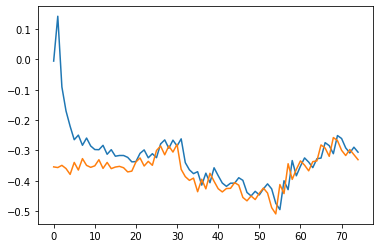

In [296]:
plt.plot(test_log)
plt.plot(change_test)

In [291]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [292]:
preds

array([87.501651, 101.953969, 93.440853, 79.866716, 65.438208, 51.735970,
       41.401238, 32.265610, 25.623069, 19.934464, 15.367964, 11.842529,
       9.228400, 7.030004, 5.417789, 4.107212, 3.119252, 2.368896,
       1.790648, 1.338638, 1.001316, 0.764559, 0.588876, 0.444673,
       0.339229, 0.256213, 0.200380, 0.158360, 0.122478, 0.096727,
       0.075248, 0.059631, 0.044496, 0.032625, 0.023703, 0.017300,
       0.012233, 0.008897, 0.006326, 0.004661, 0.003370, 0.002394,
       0.001688, 0.001199, 0.000852, 0.000613, 0.000438, 0.000305,
       0.000210, 0.000146, 0.000101, 0.000071, 0.000050, 0.000035,
       0.000024, 0.000016, 0.000011, 0.000008, 0.000006, 0.000004,
       0.000003, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001,
       0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
       0.000000, 0.000000, 0.000000])

In [42]:
for index, row in df.iterrows():
    print(row['ticker'])

AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL
AAPL


In [43]:
df

,id,ticker,date,price_close,price_open,price_high,price_low,volume
0,1,AAPL,03/10/2019,55.21,54.61,55.24,53.78,121410744.0
1,2,AAPL,04/10/2019,56.75,56.41,56.87,55.97,139022212.0
2,3,AAPL,07/10/2019,56.77,56.57,57.48,56.46,123557076.0
3,4,AAPL,08/10/2019,56.10,56.46,57.02,56.08,117130800.0
4,5,AAPL,09/10/2019,56.76,56.76,56.95,56.41,76117696.0
...,...,...,...,...,...,...,...,...
248,249,AAPL,28/09/2020,114.96,115.01,115.32,112.78,137672403.0
249,250,AAPL,29/09/2020,114.09,114.55,115.31,113.57,100060526.0
250,251,AAPL,30/09/2020,115.81,113.79,117.26,113.62,142675184.0
251,252,AAPL,01/10/2020,116.79,117.64,117.72,115.83,116120440.0
